In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore') # filter some warning messages
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
import seaborn as sns
import glob
import os
import fnmatch
import calendar

In [2]:
# Generals
ldp = '/Users/sol/Documents/LargeData/' # data folder
months=['January','February','March','April','May','June','July','August','September','October','November','December']

# regional domain
ldom = np.array([[46.5,47.5],[-125.1,-124]])
# QIN domain
qbox = np.array([[-124.05,-124.33,-125.07,-124.774,-124.05],[46.53,47.4,47.4,46.53,46.53]]) 

#palette=plt.get_cmap("Spectral").reversed()
#palette=plt.get_cmap("YlGnBu").reversed()
#palette=plt.get_cmap("coolwarm").reversed()
palette=plt.get_cmap("RdYlGn")


In [3]:
# qin mask
qin = xr.open_dataset(ldp+'/QIN/qin_mask.nc')
qin.close()
qin.coords['lon'] = np.mod(qin.coords['lon'] + 180,360) - 180
qin = qin.polygon_mask.sel(lat=slice(ldom[0,0],ldom[0,1]),lon=slice(ldom[1,0],ldom[1,1]))
qin = qin.where(qin!=0,np.nan)

In [4]:
fishdt = pd.read_csv('../data/QiN_dataspecifics.csv')
# https://docs.google.com/spreadsheets/d/1zYiVVgZR4DLksM_yABO_zPnsXe7Q6Uh_8tvxt3n60N0/edit?usp=sharing')
# Transform O2
fishdt['Om'] = fishdt['Om']/44.661
fishes=fishdt['Species']
var = ['thetao','o2']   
depth = ['surface','bottom']
ssps = ['ssp245','ssp585']

In [5]:
def get_suitable_habitat_values(x, m, s, z):
    func = lambda x, m, s, z: z * np.exp(-0.5*((x - m)/s)**2)
    return xr.apply_ufunc(func, x, m, s, z)

def T_weighted_suitable_habitat(fishnum, ds_tmp):
    import math
    
    # generate mask for final tally
    mask1 = ds_tmp.where((ds_tmp>=fishdt['Tm'][fishnum])&(ds_tmp<=fishdt['Tx'][fishnum]), np.nan)*0 + 1
    mask2 = ds_tmp.where((ds_tmp<=fishdt['Tm'][fishnum])|(ds_tmp>=fishdt['Tx'][fishnum]), np.nan)*0
    mask = xr.concat((mask1,mask2),'z').mean(dim='z')
    #mask = ds_tmp.where((ds_tmp>=Trange[fishnum,0])&(ds_tmp<=Trange[fishnum,1]), np.nan)
    
    # define normal distribution for the t range and set values
    m = (fishdt['Tx'][fishnum]+fishdt['Tm'][fishnum])/2
    s = (fishdt['Tx'][fishnum]-fishdt['Tm'][fishnum])*0.68/2
    # scale to 0-1
    xw = np.arange(fishdt['Tm'][fishnum], fishdt['Tx'][fishnum], 0.01)
    z = 1/s/np.sqrt(2*math.pi)
    yw = z * np.exp(-0.5*((xw - m)/s)**2)
    ymin = yw.min()
    ymax = (yw-ymin).max()
    #ymax = yw.max()
    #plt.plot(xw, (yw-ymin)/ymax)
    #plt.show()
    
    ds_new = get_suitable_habitat_values(ds_tmp, m, s, z)
    ds_new = (ds_new - ymin)*100 / ymax
    #ds_new = (ds_new)*100 / ymax
    ds_new = ds_new * mask
    
    return ds_new
    

In [6]:
def suitable_habitat_monthly_allmod_comb(fishnum):            
    # decades to average
    yrsav = [*range(1990,2100,10)]
    
    for clim in ssps:
        for i2 in depth:
            # for each variable at given depth
            for i in var:
                tmp1 = np.full((len(qin.lat.values),len(qin.lon.values),len(yrsav),9),np.nan)
                # optimal range thresholds
                if i=='thetao':
                    th1 = fishdt['Tm'][fishnum]
                    th2 = fishdt['Tx'][fishnum]
                else:
                    if fishdt['Om'][fishnum]<=1.4:
                        th1 = 1.4
                    else:
                        th1 = fishdt['Om'][fishnum]
                # for each model
                fns = glob.glob(ldp+'/QIN/downscaled_data/'+clim+'/'+i+'/'+i2+'/*.nc')
                # build datasets from all models
                for modn,fn in enumerate(fns):
                    # model name
                    tmps = fn.split('/')
                    tmps2 = tmps[-1].split('_')
                    modname = tmps2[0]+'_'+tmps2[1]
                    #print(modn,models[nummod])
                    ds_Ts = xr.open_dataset(fn)
                    ds_Ts.close()
                    ds_Ts.coords['lon'] = np.mod(ds_Ts.coords['lon'] + 180,360) - 180
                    # select only region of interest (large)
                    ds_Ts = ds_Ts[i].sel(lat=slice(ldom[0,0],ldom[0,1]),lon=slice(ldom[1,0],ldom[1,1]),time=slice('1994-01-01','2099-12-31'))
                    # mask qin region
                    ds_Ts = ds_Ts*qin
                    
                    if i=='thetao':
                        # calculate suitable habitat for T
                        tmp = T_weighted_suitable_habitat(fishnum, ds_Ts)
                    else:
                        #tmp = ds_Ts.where((ds_Ts>=th1)&(ds_Ts<=th2), np.nan)
                        tmp = ds_Ts.where(ds_Ts<th1, 1)
                        tmp = tmp.where(tmp==1, 0)
                        tmp = tmp*qin
                    
                    # data array
                    if modn==0:
                        fechas = ds_Ts.time
                    tmp_ds = xr.DataArray(data=tmp,dims=['time','lat','lon'],
                                        coords=dict(time=fechas,lat=ds_Ts.lat,lon=ds_Ts.lon))
                    
                    if i=='thetao':
                        if modn==0: 
                            allmodT = xr.Dataset({modname:tmp_ds})
                        else:
                            allmodT[modname] = tmp_ds
                    else:
                        if modn==0: 
                            allmodO = xr.Dataset({modname:tmp_ds})
                        else:
                            allmodO[modname] = tmp_ds
                    
            # compare that both vars in each models
            # for each model that has Oxygen
            di = 0
            for i in list(allmodO):
                tmpO = allmodO[i].values
                try:
                    tmpT = allmodT[i].values
                    OTcomb = tmpO * tmpT
                    tmpT = xr.DataArray(data=tmpT, dims=['time','lat','lon'],
                                        coords=dict(time=fechas,lat=ds_Ts.lat,lon=ds_Ts.lon))
                    
                    tmpO = xr.DataArray(data=tmpO, dims=['time','lat','lon'],
                                        coords=dict(time=fechas,lat=ds_Ts.lat,lon=ds_Ts.lon))
                    
                    tmp_OT = xr.DataArray(data=OTcomb, dims=['time','lat','lon'],
                                        coords=dict(time=fechas,lat=ds_Ts.lat,lon=ds_Ts.lon))
                    # suitable habitat
                    Sh_tmp = tmp_OT.mean(dim=['lat','lon']).values
                    
                    tmp = xr.DataArray(data=Sh_tmp, dims=['time'], coords=dict(time=fechas))
                    if di==0:
                        allmod_otcomb = xr.Dataset({i:tmp})
                        di += 1
                    else:
                        allmod_otcomb[i] = tmp
                except:
                    x=1
            
            varns = clim+'_'+i2
            allmod_otcomb.to_netcdf(ldp+'QIN/downscaled_data/suitable_habitat_v2/OT_monthly_'+fishes[fishnum]+'_'+varns+'_allmods.nc')
                

In [7]:
fishdt

,Species,Dx,Dm,Tx,Tm,Om,xDist,Level,Period
0,Dungeness Crab,90,41,11.72,5.36,2.416202,89,1,p
1,Razor Clams,28,5,12.73,5.99,2.472851,59,0,p
2,Sablefish,1450,175,12.85,4.72,0.786592,241,1,p
3,Pacific Halibut,515,155,9.28,2.92,1.246501,230,1,p
4,Chinook,172,43,11.65,3.49,1.218513,230,2,p
5,Coho,118,28,12.35,4.43,1.319720,147,0,p
6,Sockeye,118,28,10.45,4.39,0.558877,189,0,p
7,Rockfish,462,145,10.00,4.80,0.787488,205,1,p
8,Hake,229,126,23.29,1.18,2.485390,169,2,f
9,Albacore,400,0,19.40,12.20,3.232350,322,0,f


In [ ]:
for fishn in range(len(fishes)):
    suitable_habitat_monthly_allmod_comb(fishn)


In [8]:
def plot_decadal_timseries_ensemble(fish, dp, ssp):
    ds = xr.open_dataset(ldp+'QIN/downscaled_data/suitable_habitat_v2/OT_monthly_'+fish+'_'+ssp+'_'+dp+'_allmods.nc')
    ds.close()

    yrsav = [*range(1990,2101,10)]
    yrs = ds.time.dt.year.values
    Sh_Ts_dec = np.full((len(yrsav)-1,len(list(ds))),np.nan)
    for idx,i in enumerate(list(ds)):
        for j in range(len(yrsav)-1):
            a=(yrs>=yrsav[j])&(yrs<=yrsav[j+1])
            tmp = ds[i].values
            Sh_Ts_dec[j,idx] = np.nanmean(tmp[a])

    plt.figure(figsize=(6,3),dpi=150)
    plt.plot(yrsav[:-1], Sh_Ts_dec,'.-',c='grey', alpha=0.6,zorder=1)
    plt.errorbar(yrsav[:-1], np.nanmean(Sh_Ts_dec, axis=1), yerr=np.nanstd(Sh_Ts_dec, axis=1),c='firebrick', lw=3, zorder=2)
    plt.grid(True, alpha=0.3, zorder=0)
    plt.title(fish+', '+dp.capitalize()+', '+ssp.upper())
    plt.ylabel('Suitable Habitat (%)', fontsize=12)
    plt.ylim([0,100])
    plt.savefig('../figures/suitable_habitat/decadal/OT_'+fish+'_'+dp+'_'+ssp+'_timeseries.png')
    plt.show()
    
    # calculate diference
    
    xx = Sh_Ts_dec[0]-Sh_Ts_dec[-1]# begining - 2100
    yy = Sh_Ts_dec[2]-Sh_Ts_dec[-1]# present (2010-2020) - 2100
    print(fish, ', ', ssp, ', ', dp, ', ',np.round(np.nanmean(xx),1),', ', np.round(np.nanstd(xx),1), ', ',np.round(np.nanmean(yy),1),', ', np.round(np.nanstd(yy),1)) 
    print(np.round(np.nanmean(Sh_Ts_dec[2])))

In [9]:
def plot_decadal_hovmuller_ensemble(fish, dp, ssp):
    # plot hovmuller
    ds = xr.open_dataset(ldp+'QIN/downscaled_data/suitable_habitat_v2/OT_monthly_'+fish+'_'+ssp+'_'+dp+'_allmods.nc')
    ds.close()

    yrsav = [*range(1990,2101,10)]
    yrs = np.unique(ds.time.dt.year.values)
    Sh_Ts_dec_hv = np.full((len(yrsav)-1,12,len(list(ds))),np.nan)

    for idx,i in enumerate(list(ds)): # for each model
        tmp = ds[i].values
        tmp = tmp.reshape((int(len(tmp)/12)), 12)
        for j in range(len(yrsav)-1): # for each decade
            a=(yrs>=yrsav[j])&(yrs<=yrsav[j+1])
            for k in range(12):
                Sh_Ts_dec_hv[j,k,idx] = np.nanmean(tmp[a,k])

    Sh_Ts_dec_hvm = np.full((12,len(yrsav)-1),np.nan)
    Sh_Ts_dec_hvs = np.full((12,len(yrsav)-1,),np.nan)
    for j in range(len(yrsav)-1):
        for i in range(12):
            Sh_Ts_dec_hvm[i,j] = np.nanmedian(Sh_Ts_dec_hv[j,i,:])
            Sh_Ts_dec_hvs[i,j] = np.nanstd(Sh_Ts_dec_hv[j,i,:])

    plt.figure(figsize=(7.5,3.5), dpi=150)
    ax=sns.heatmap(Sh_Ts_dec_hvm, yticklabels=months, xticklabels=yrsav[:-1], linewidths=0, alpha=0.8, vmin=0, vmax=100, cmap=palette, cbar_kws={'label': 'Suitable Habitat (%)'})
    X2, Y2 = np.meshgrid(np.arange(0.5,len(yrsav[:-1])),np.arange(0.5,12))
    plt.scatter(X2, Y2, s=Sh_Ts_dec_hvs,c='w',marker='o', edgecolor='grey', alpha=0.6)
    plt.title(fish+', '+dp.capitalize()+', '+ssp.upper())
    plt.tight_layout()
    plt.savefig('../figures/suitable_habitat/decadal/OT_'+fish+'_'+dp+'_'+ssp+'_hovmuller.png')
    plt.show()
    

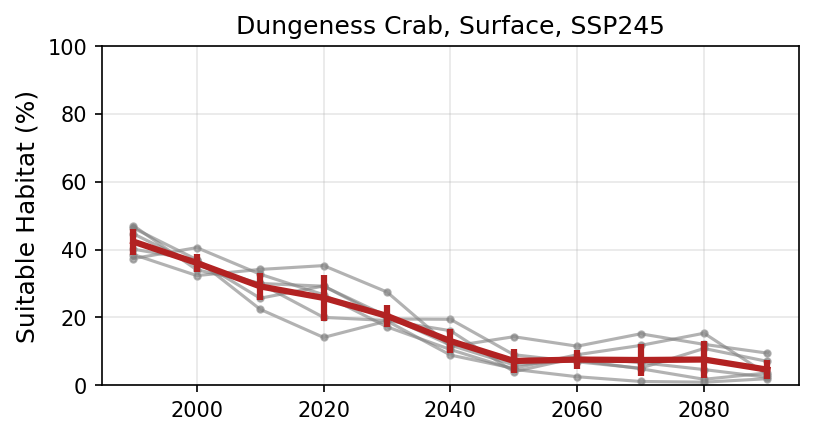

Dungeness Crab ,  ssp245 ,  surface ,  37.7 ,  5.5 ,  24.5 ,  4.4
29.0


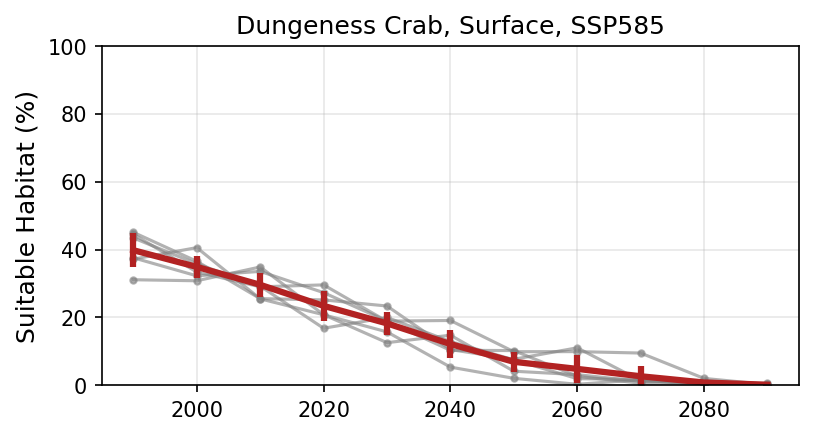

Dungeness Crab ,  ssp585 ,  surface ,  39.6 ,  4.9 ,  29.4 ,  3.7
30.0


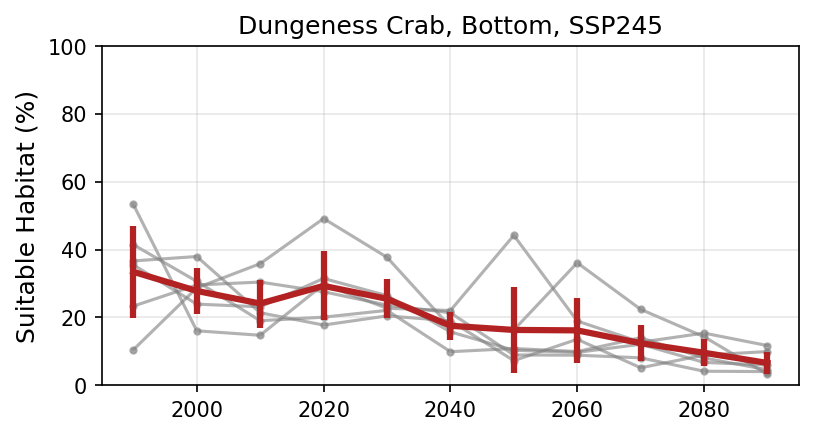

Dungeness Crab ,  ssp245 ,  bottom ,  26.8 ,  11.3 ,  17.5 ,  9.7
24.0


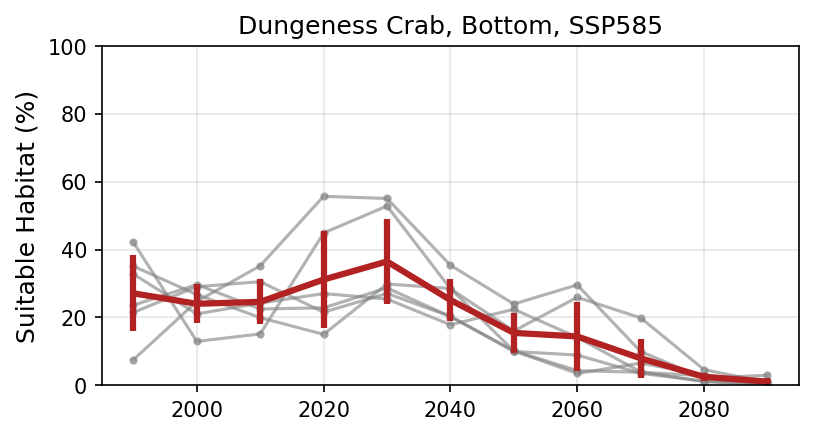

Dungeness Crab ,  ssp585 ,  bottom ,  26.0 ,  11.8 ,  23.5 ,  6.1
25.0


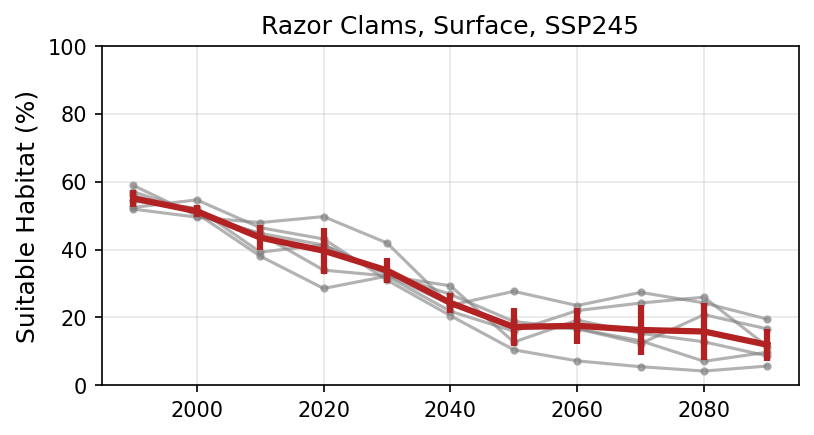

Razor Clams ,  ssp245 ,  surface ,  43.1 ,  6.1 ,  31.6 ,  6.2
43.0


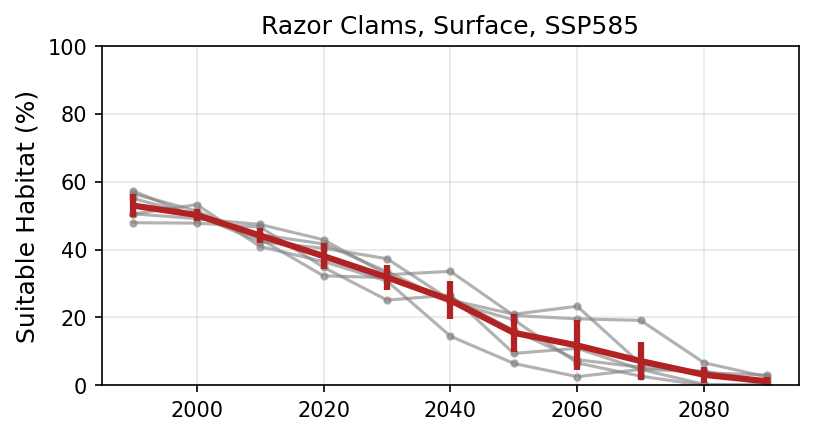

Razor Clams ,  ssp585 ,  surface ,  51.7 ,  3.5 ,  42.9 ,  2.5
44.0


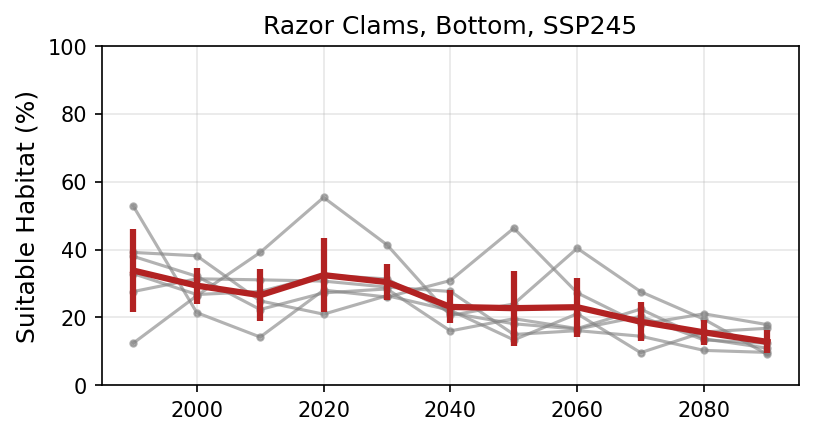

Razor Clams ,  ssp245 ,  bottom ,  21.0 ,  9.6 ,  13.7 ,  10.5
27.0


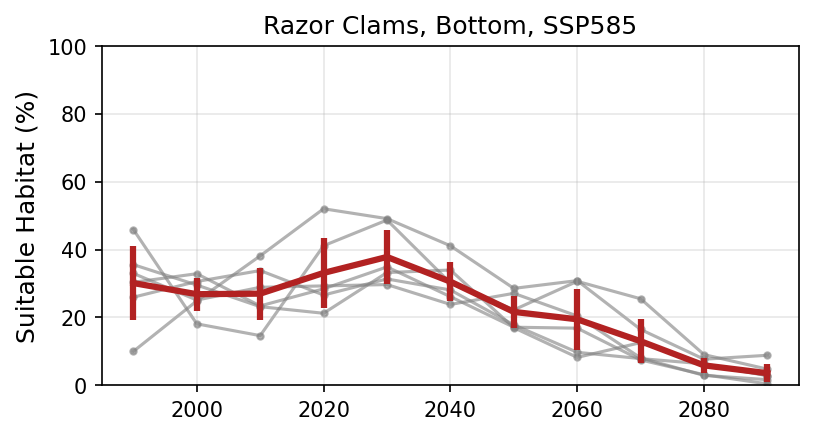

Razor Clams ,  ssp585 ,  bottom ,  26.5 ,  12.5 ,  23.4 ,  7.0
27.0


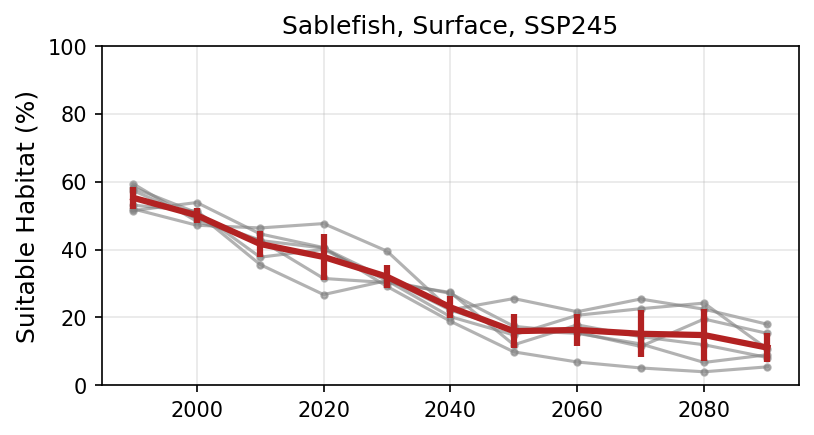

Sablefish ,  ssp245 ,  surface ,  44.1 ,  6.1 ,  30.5 ,  5.8
42.0


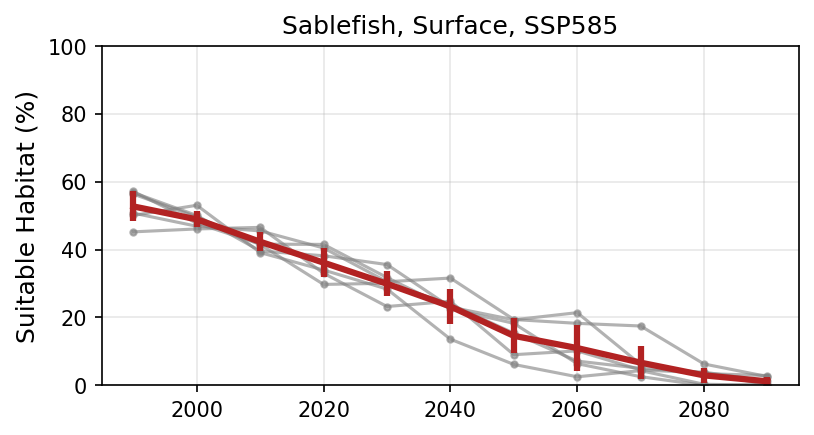

Sablefish ,  ssp585 ,  surface ,  51.5 ,  4.1 ,  41.1 ,  3.0
42.0


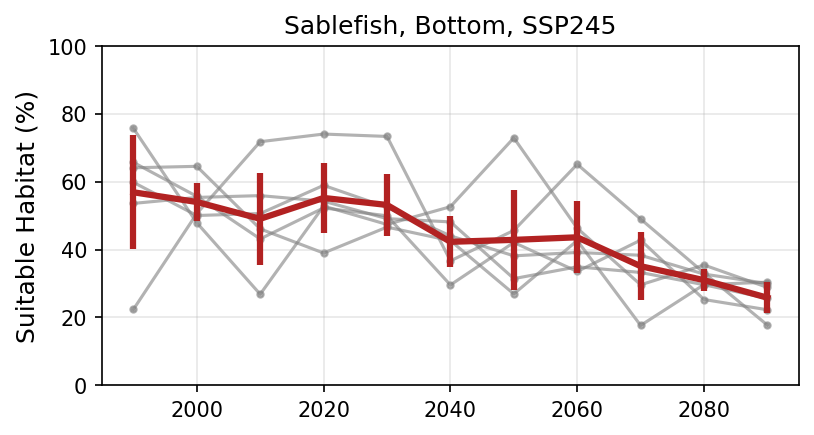

Sablefish ,  ssp245 ,  bottom ,  31.0 ,  13.7 ,  23.2 ,  16.8
49.0


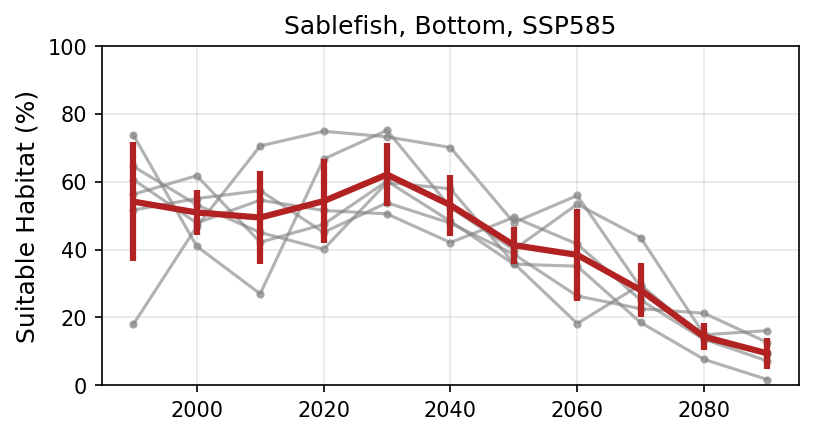

Sablefish ,  ssp585 ,  bottom ,  44.7 ,  20.6 ,  40.0 ,  11.2
49.0


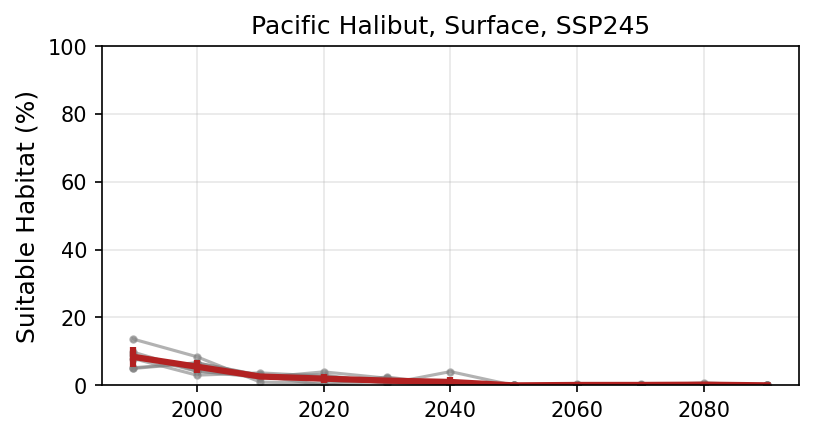

Pacific Halibut ,  ssp245 ,  surface ,  8.4 ,  3.0 ,  2.6 ,  0.8
3.0


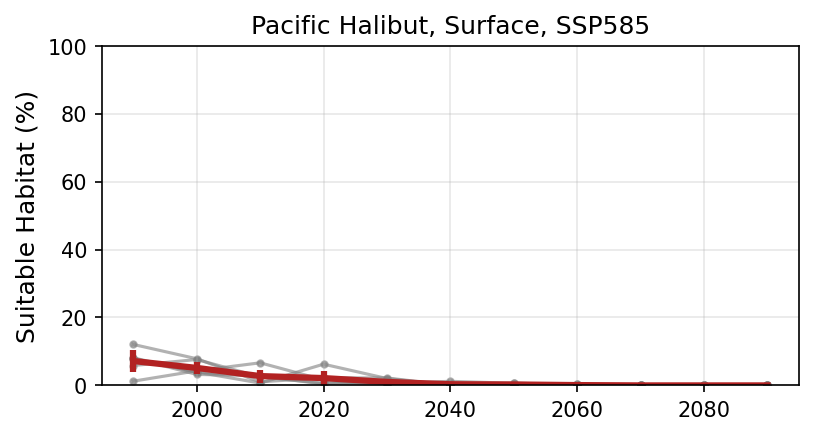

Pacific Halibut ,  ssp585 ,  surface ,  7.2 ,  3.2 ,  2.7 ,  1.9
3.0


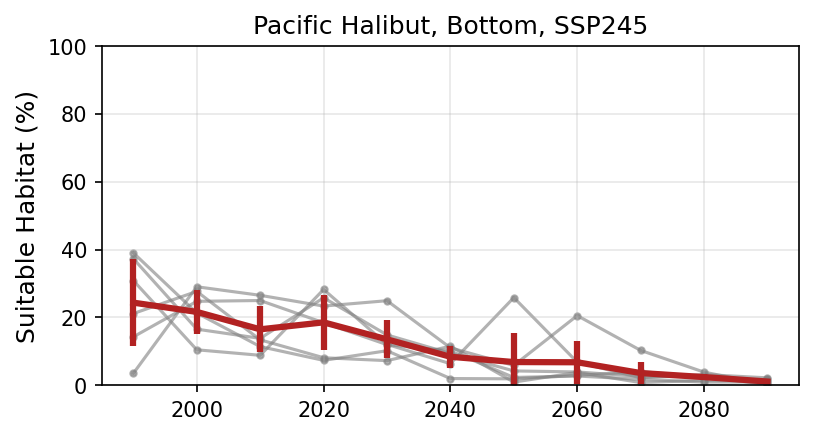

Pacific Halibut ,  ssp245 ,  bottom ,  23.2 ,  12.5 ,  15.4 ,  7.2
17.0


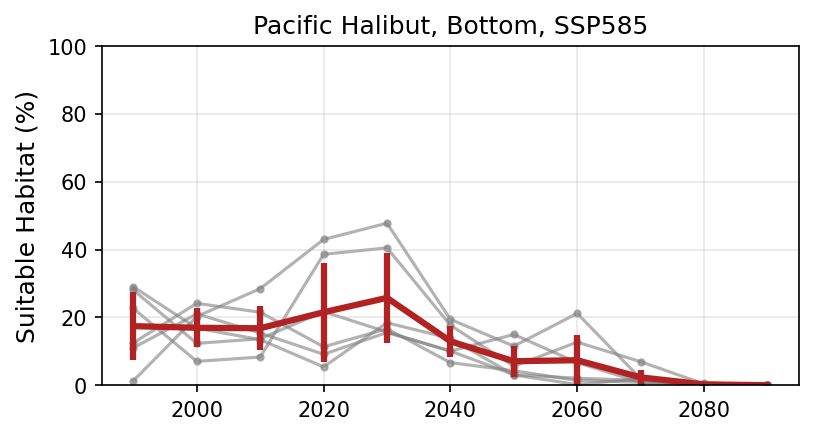

Pacific Halibut ,  ssp585 ,  bottom ,  17.4 ,  10.0 ,  16.8 ,  6.4
17.0


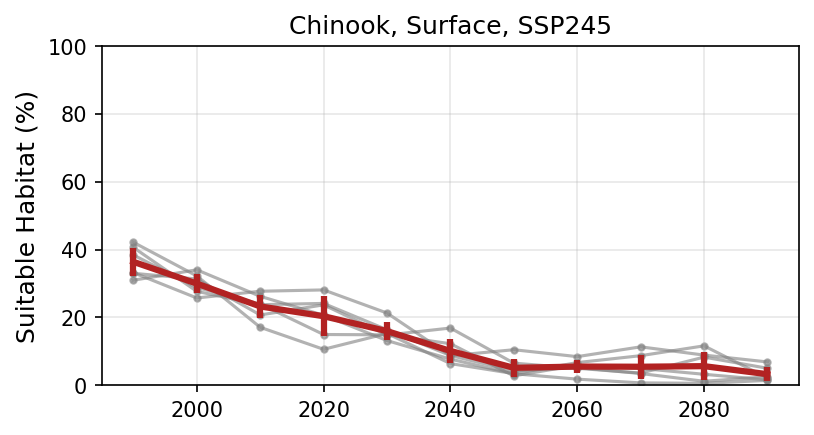

Chinook ,  ssp245 ,  surface ,  33.1 ,  5.3 ,  20.0 ,  3.5
23.0


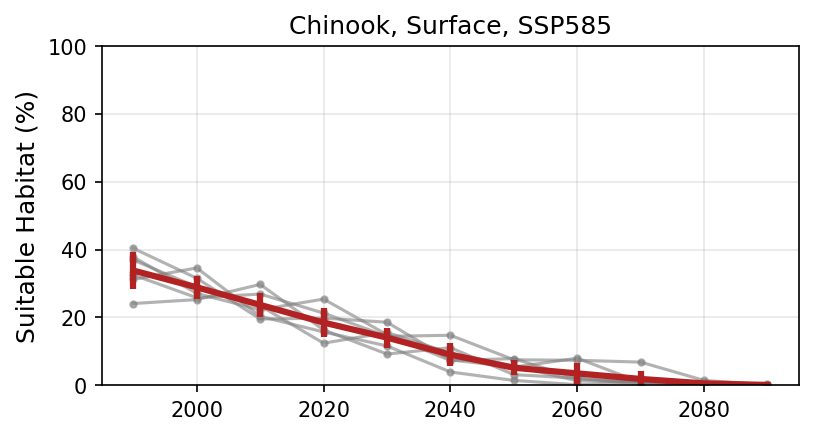

Chinook ,  ssp585 ,  surface ,  33.7 ,  5.2 ,  23.6 ,  3.6
24.0


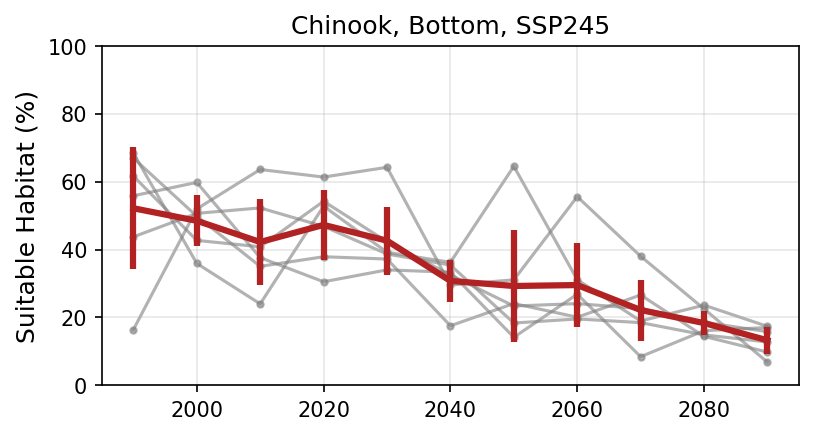

Chinook ,  ssp245 ,  bottom ,  38.9 ,  15.5 ,  28.9 ,  15.7
42.0


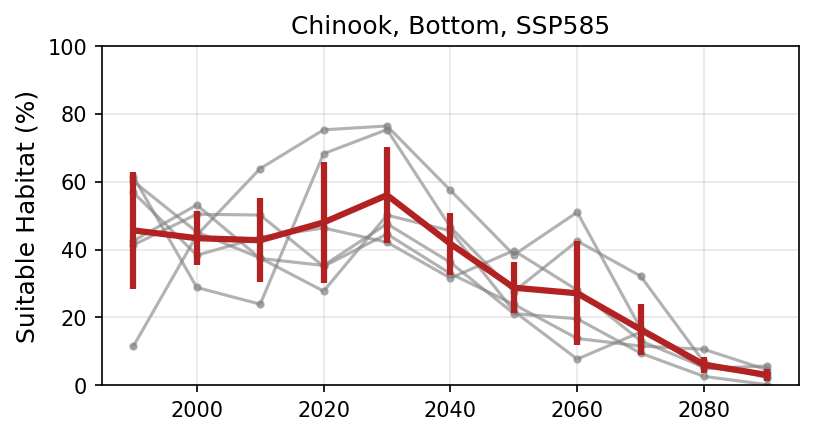

Chinook ,  ssp585 ,  bottom ,  42.6 ,  18.3 ,  39.7 ,  11.0
43.0


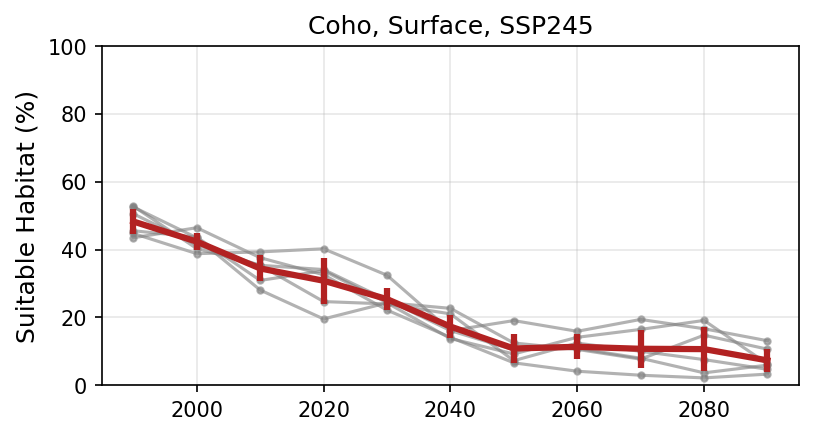

Coho ,  ssp245 ,  surface ,  40.9 ,  5.9 ,  27.1 ,  4.9
34.0


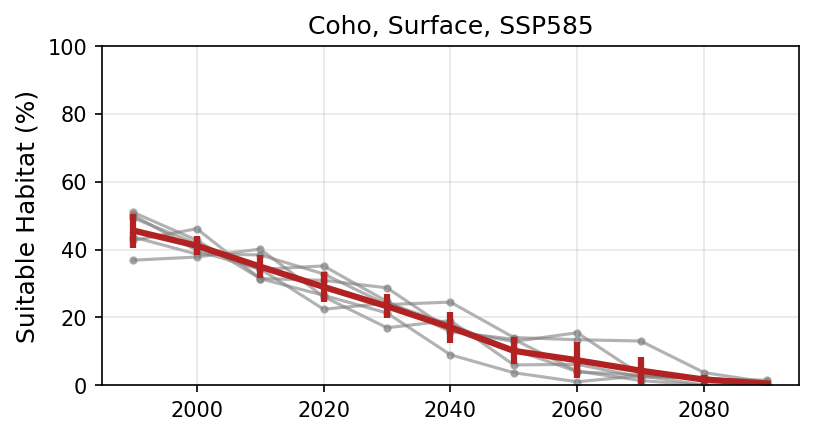

Coho ,  ssp585 ,  surface ,  45.1 ,  4.7 ,  34.4 ,  3.5
35.0


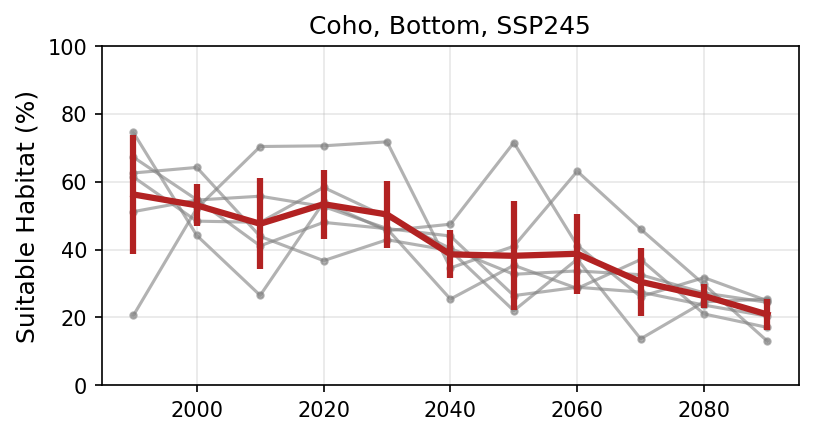

Coho ,  ssp245 ,  bottom ,  35.3 ,  14.2 ,  26.7 ,  17.0
48.0


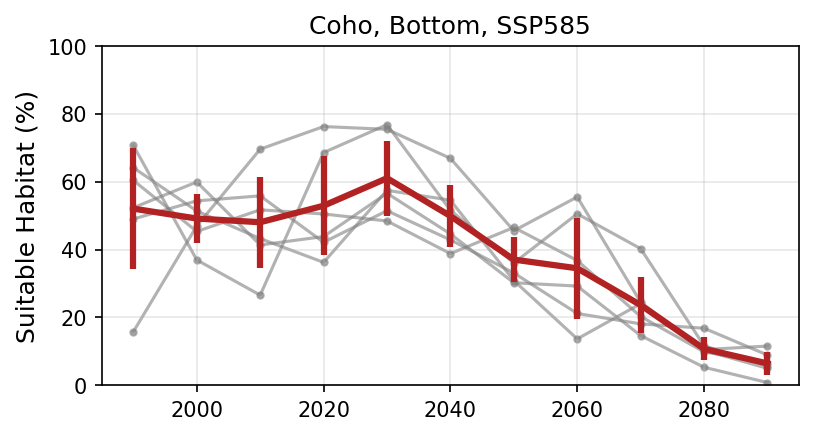

Coho ,  ssp585 ,  bottom ,  45.6 ,  20.0 ,  41.6 ,  11.2
48.0


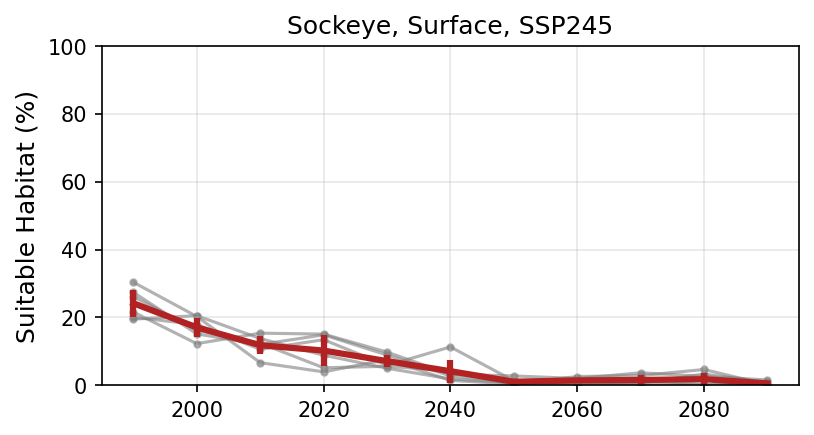

Sockeye ,  ssp245 ,  surface ,  23.6 ,  4.4 ,  11.2 ,  2.5
12.0


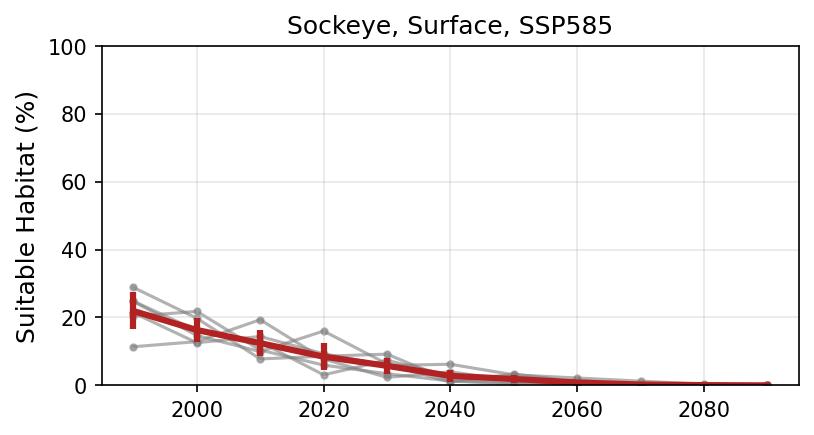

Sockeye ,  ssp585 ,  surface ,  21.9 ,  5.4 ,  12.4 ,  3.7
12.0


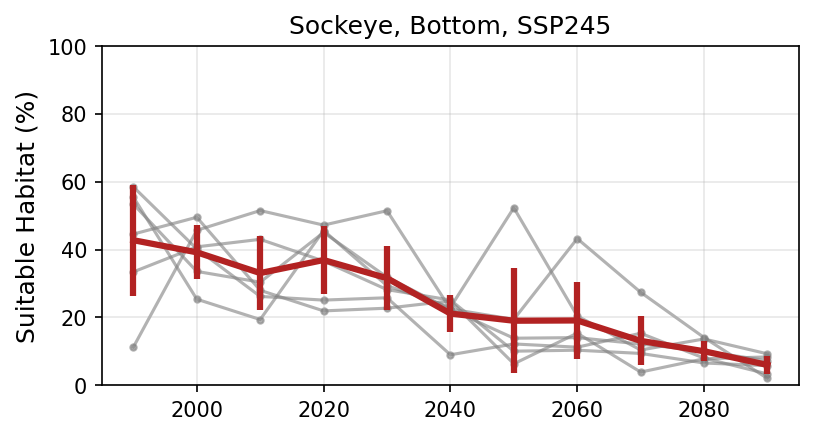

Sockeye ,  ssp245 ,  bottom ,  36.7 ,  15.0 ,  27.0 ,  12.8
33.0


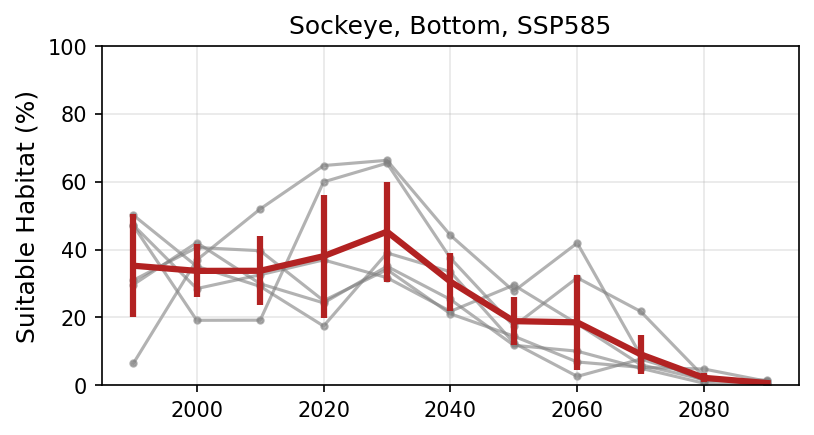

Sockeye ,  ssp585 ,  bottom ,  34.5 ,  15.5 ,  33.0 ,  9.7
34.0


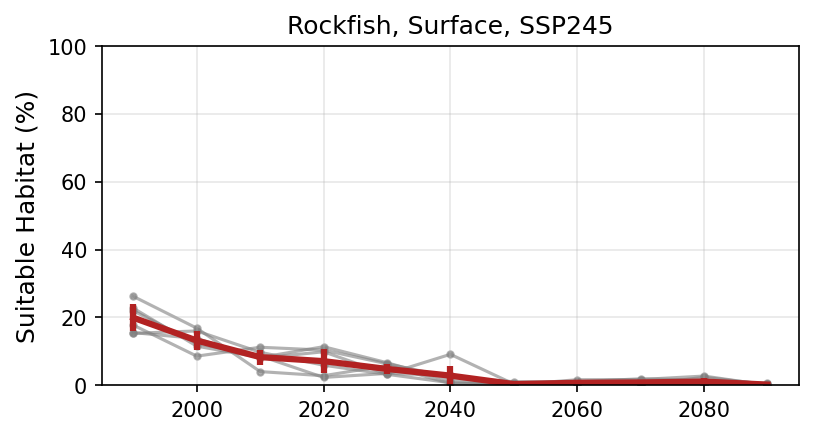

Rockfish ,  ssp245 ,  surface ,  19.7 ,  4.2 ,  8.1 ,  2.1
8.0


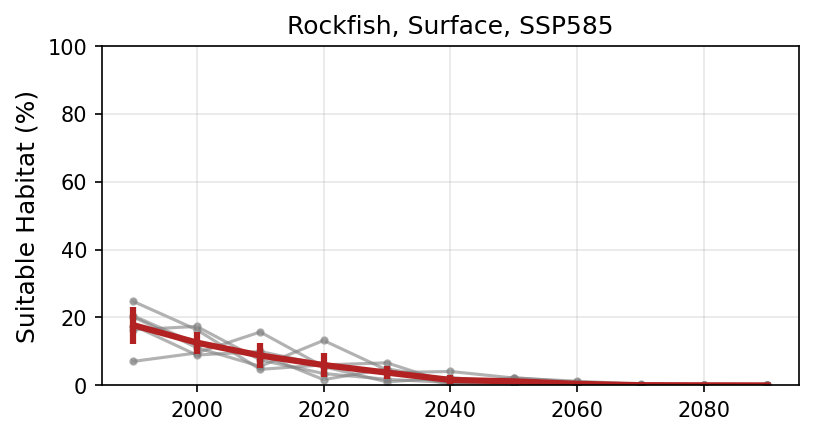

Rockfish ,  ssp585 ,  surface ,  17.7 ,  5.4 ,  8.8 ,  3.6
9.0


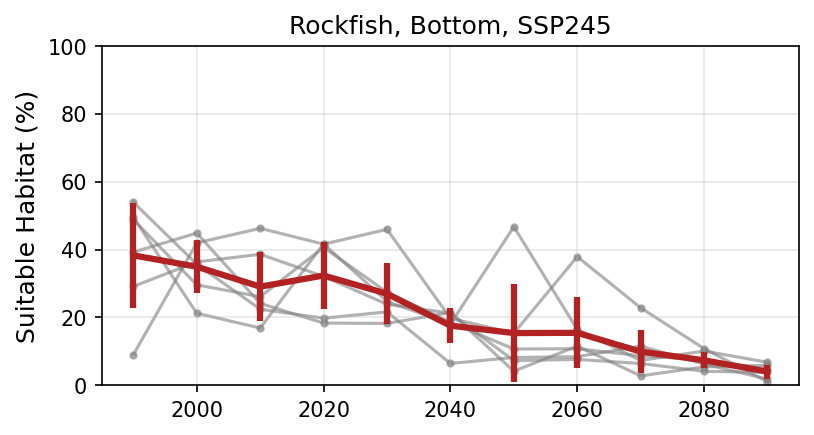

Rockfish ,  ssp245 ,  bottom ,  34.2 ,  14.5 ,  25.0 ,  11.6
29.0


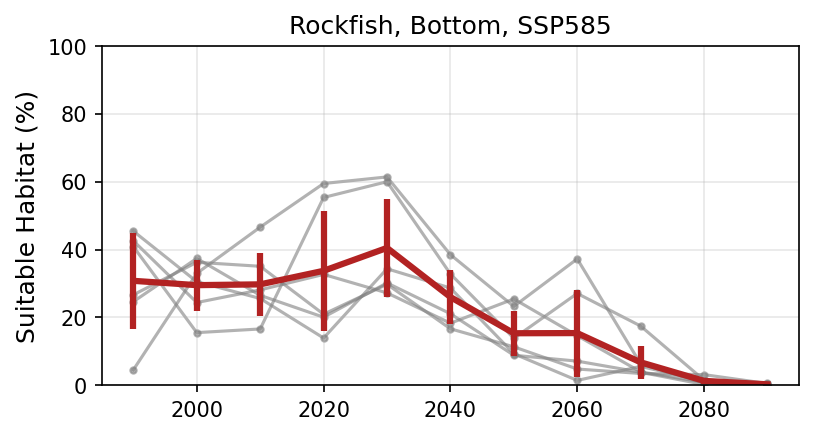

Rockfish ,  ssp585 ,  bottom ,  30.5 ,  14.3 ,  29.4 ,  9.0
30.0


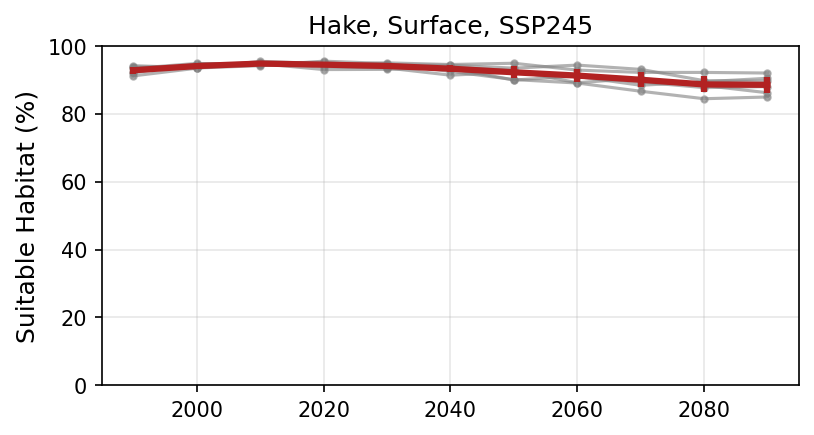

Hake ,  ssp245 ,  surface ,  4.3 ,  2.7 ,  6.3 ,  2.3
95.0


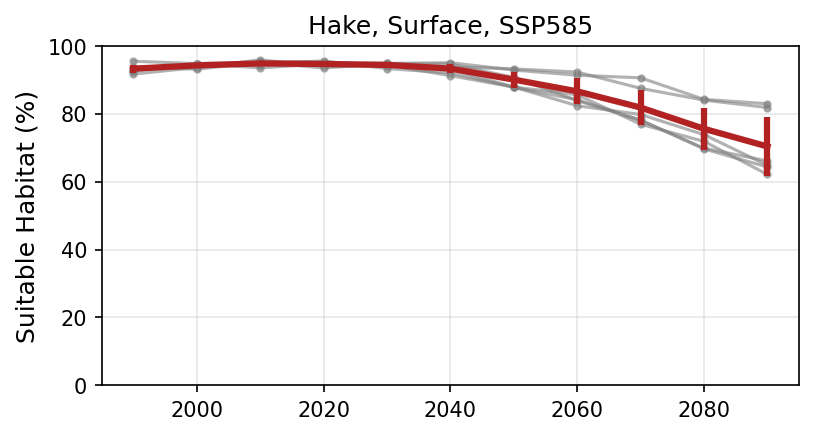

Hake ,  ssp585 ,  surface ,  22.9 ,  9.3 ,  24.4 ,  8.3
95.0


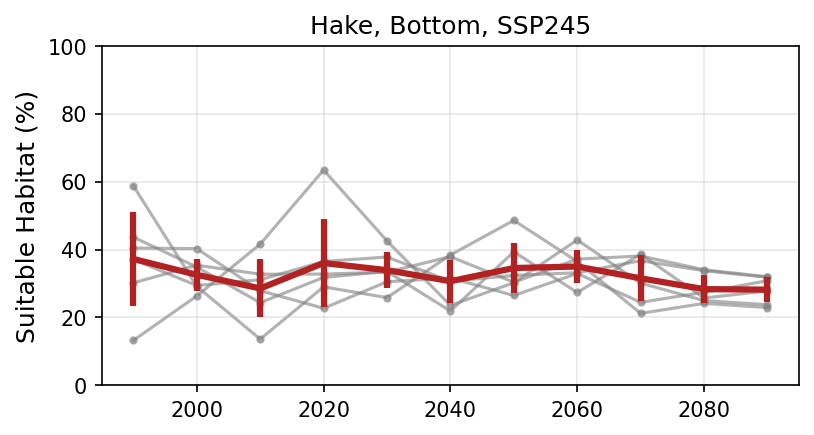

Hake ,  ssp245 ,  bottom ,  9.0 ,  14.6 ,  0.4 ,  8.4
29.0


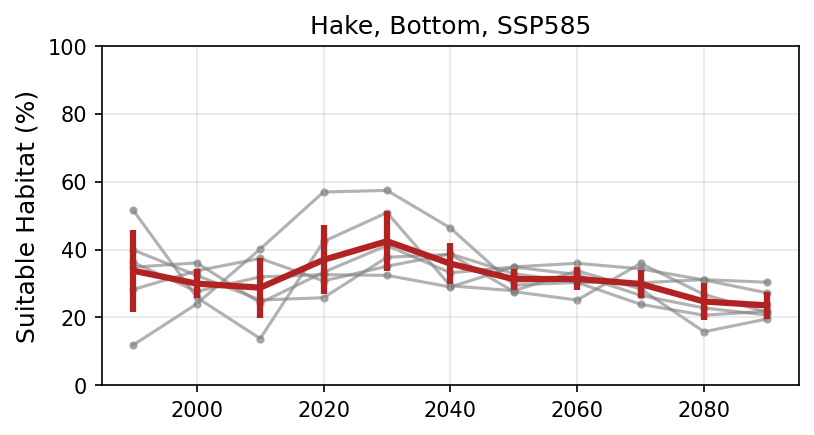

Hake ,  ssp585 ,  bottom ,  10.2 ,  13.6 ,  5.2 ,  7.1
29.0


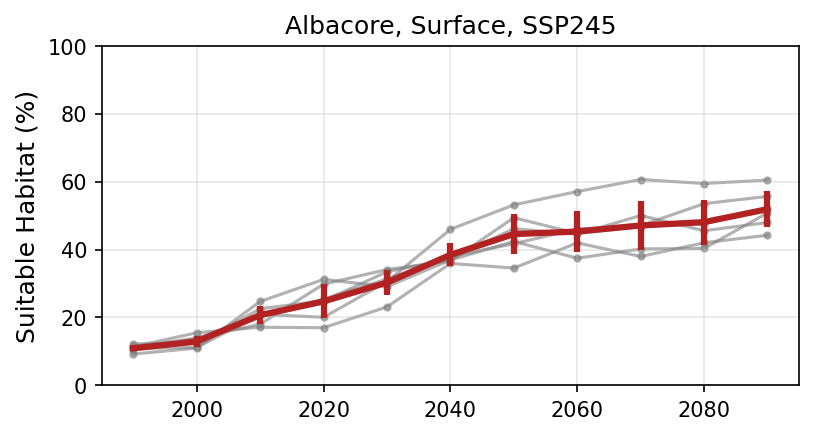

Albacore ,  ssp245 ,  surface ,  -40.9 ,  5.6 ,  -31.2 ,  5.3
21.0


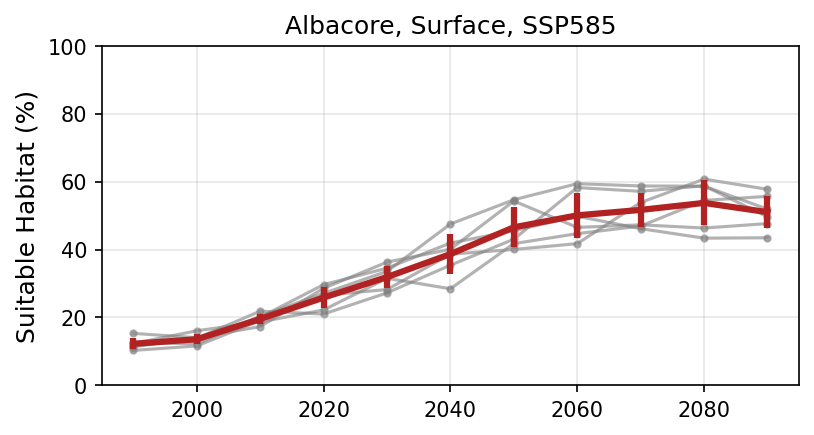

Albacore ,  ssp585 ,  surface ,  -38.7 ,  5.6 ,  -31.4 ,  5.2
20.0


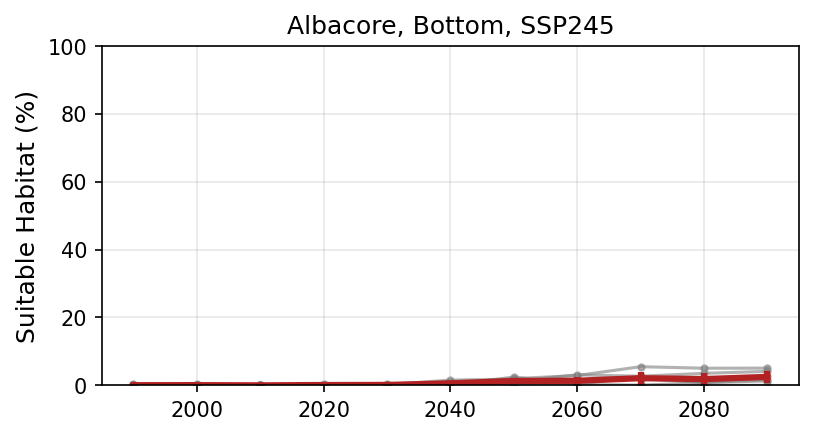

Albacore ,  ssp245 ,  bottom ,  -2.4 ,  1.7 ,  -2.5 ,  1.7
0.0


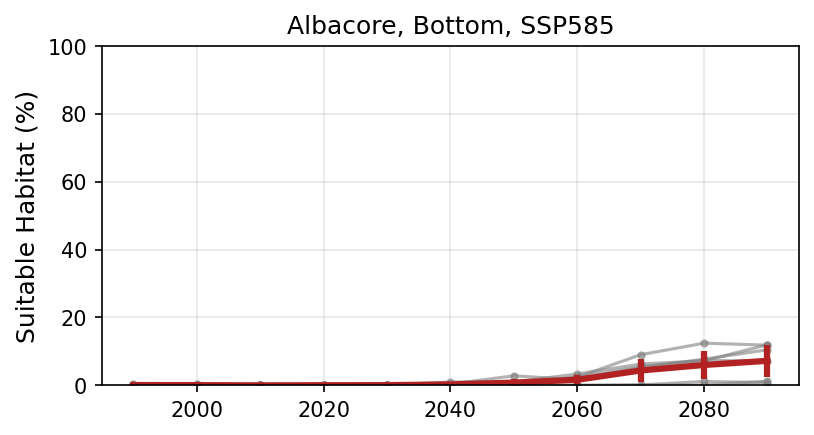

Albacore ,  ssp585 ,  bottom ,  -7.1 ,  4.7 ,  -7.2 ,  4.7
0.0


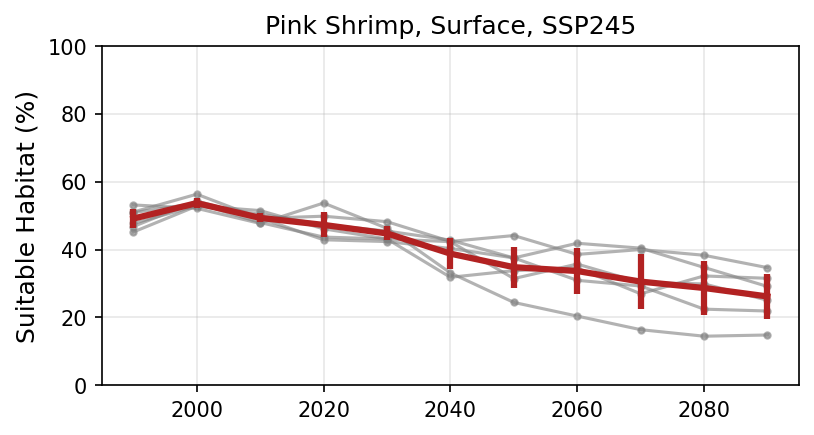

Pink Shrimp ,  ssp245 ,  surface ,  22.9 ,  7.6 ,  23.1 ,  6.4
49.0


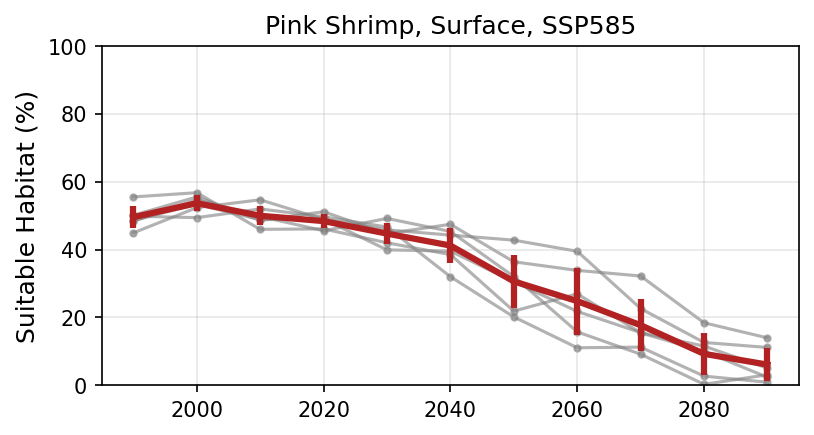

Pink Shrimp ,  ssp585 ,  surface ,  43.4 ,  6.8 ,  43.8 ,  4.9
50.0


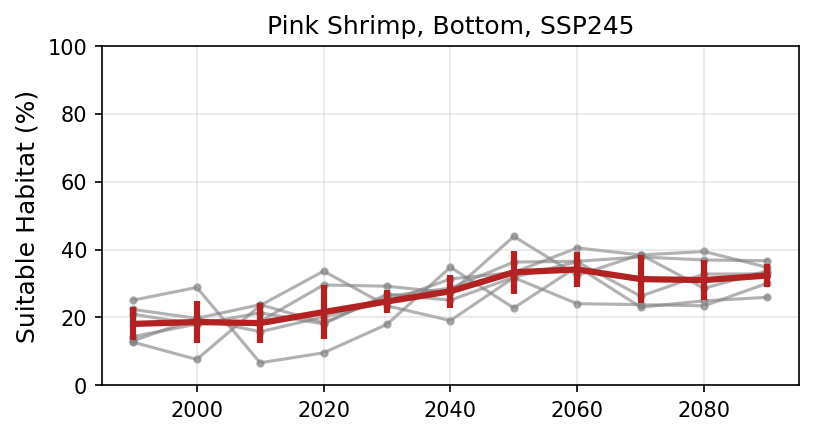

Pink Shrimp ,  ssp245 ,  bottom ,  -14.2 ,  7.2 ,  -14.0 ,  4.4
18.0


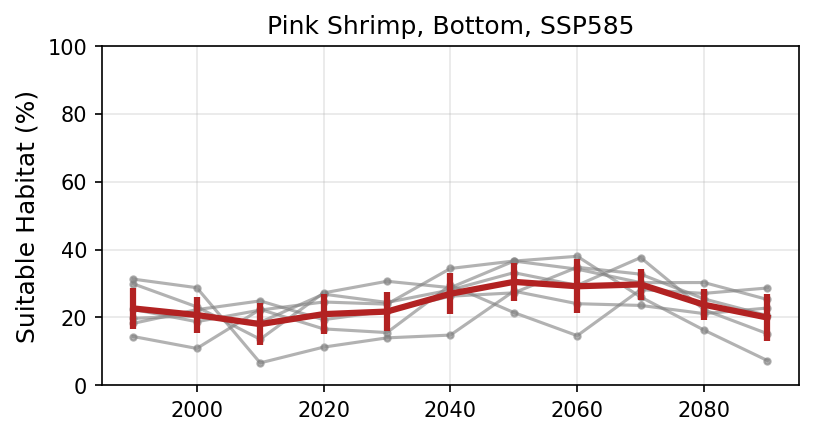

Pink Shrimp ,  ssp585 ,  bottom ,  2.7 ,  11.4 ,  -1.9 ,  7.7
18.0


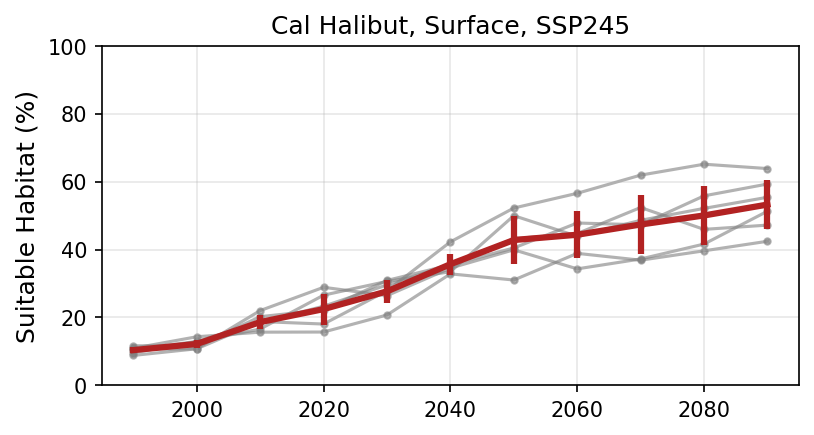

Cal Halibut ,  ssp245 ,  surface ,  -42.8 ,  7.5 ,  -34.6 ,  7.2
19.0


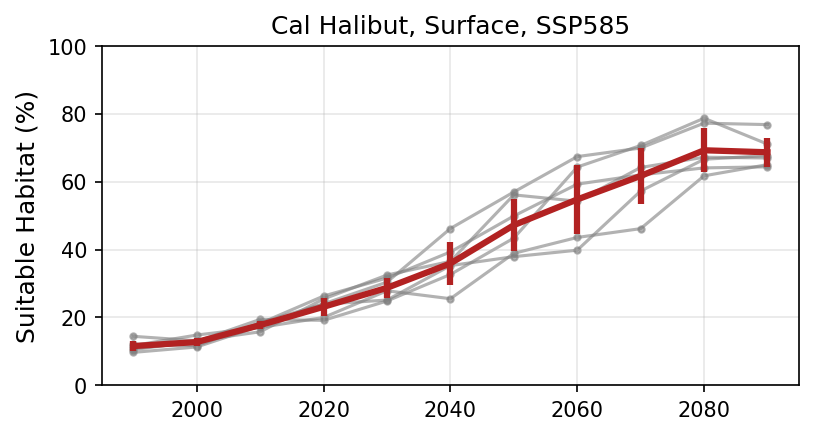

Cal Halibut ,  ssp585 ,  surface ,  -57.0 ,  4.4 ,  -50.9 ,  3.8
18.0


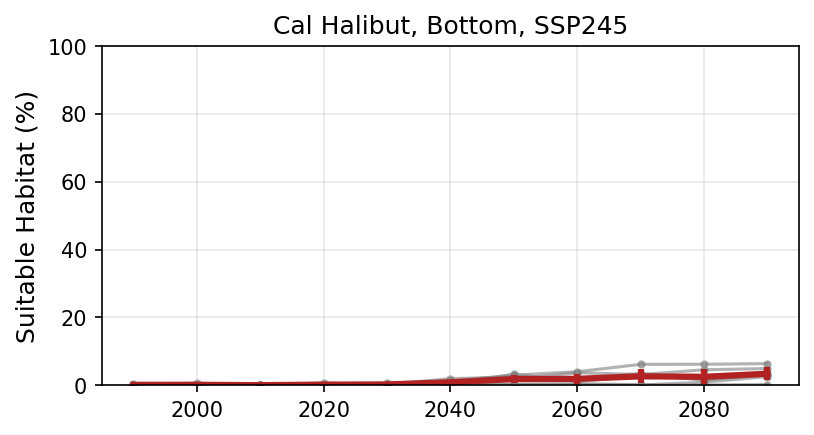

Cal Halibut ,  ssp245 ,  bottom ,  -3.3 ,  2.0 ,  -3.4 ,  1.9
0.0


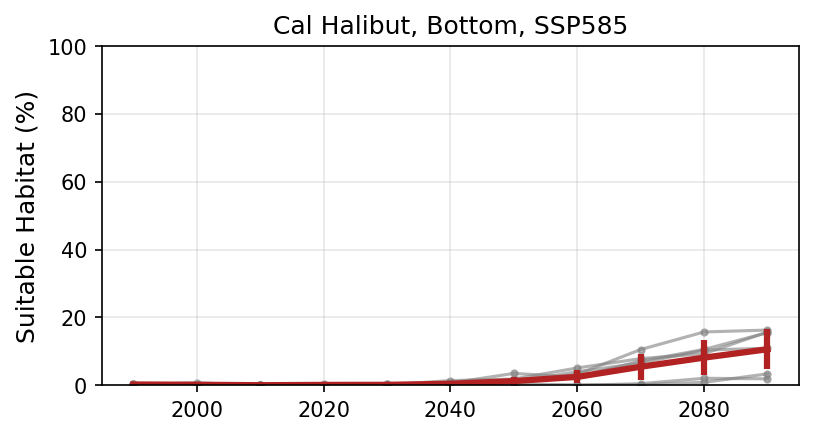

Cal Halibut ,  ssp585 ,  bottom ,  -10.4 ,  6.0 ,  -10.6 ,  5.9
0.0


In [10]:
for fish in fishes:
    for dp in depth:
        for scenario in ssps:
            plot_decadal_timseries_ensemble(fish, dp, scenario)
            #plot_decadal_hovmuller_ensemble(fish, dp, scenario)
